In [1]:
# import Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential 
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint


# Preparing data

In [2]:
# load datasets
normal_traffic_df = pd.read_csv('../DataSet/normal_dataset.csv')
normal_traffic_df.drop(columns=['Label'],inplace=True)

normal_traffic_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
normal_traffic_df.dropna(inplace=True)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [11]:
# split normal dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
normal_traffic_df=scaler.fit_transform(normal_traffic_df)

traffic_normal_train, traffic_normal_test = train_test_split(normal_traffic_df, test_size=0.20, random_state=42)

# Build the Model 

In [4]:
#build Encoder and Decoder
def build_Encoder(input_dim):
    Encoder_output_dim=8
    model= Sequential() 
    model.add(Dense(58,input_dim=input_dim,name="Encoder Reduction to 58 "))
    model.add(Dense(38,activation="LeakyReLU",name="Encoder Reduction to 38 "))
    model.add(Dense(18,activation="LeakyReLU",name="Encoder Reduction to 18"))
    model.add(Dense(Encoder_output_dim,name="Encoder Output 8"))
    return model

def build_Decoder(model,Decoder_output_dim): 
     model.add(Dense(18,name="Decoder Expand to 18")) 
     model.add(Dense(38,activation="LeakyReLU",name="Decoder Expand to 38"))
     model.add(Dense(58,activation="LeakyReLU",name="Decoder Expand to 58"))
     model.add(Dense(Decoder_output_dim,name="Decoder Output 78"))
     return model


In [5]:
# Define the combined Autoencoder model
input_shape=traffic_normal_train.shape[1]
output_shape=input_shape
Encoder = build_Encoder(input_shape)
Autoencoder=build_Decoder(Encoder,output_shape,input_shape)

In [ ]:
Autoencoder.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0002,beta_1=0.5))

Autoencoder.summary()


In [96]:
from tensorflow.keras.utils import plot_model
plot_model(
    Autoencoder,
    to_file='./GAN/GAN_model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train the model

In [7]:
#for avoid a overfiting 
Early=EarlyStopping(monitor='val_loss',restore_best_weights=True,verbose=1,mode="min",patience=20)
#checkpoint function
filepath="./Autoencoder/Autoencoder_Detector.hdf5"
Checkpoint = ModelCheckpoint(filepath,monitor='val_loss', verbose=1,save_best_only= True , mode='min',period=5)

In [8]:
# Training the mode
history = Autoencoder.fit(traffic_normal_train,traffic_normal_train ,
                          validation_split=0.2, epochs=300, 
                          batch_size=1028, verbose=1,
                          callbacks=[Early,Checkpoint])

Epoch 1/2000
6388/6388 [==============================] - 164s 25ms/step - loss: 0.2735 - val_loss: 0.1539
Epoch 2/2000
6388/6388 [==============================] - 141s 22ms/step - loss: 0.1254 - val_loss: 0.1096
Epoch 3/2000
6388/6388 [==============================] - 144s 23ms/step - loss: 0.0875 - val_loss: 0.0649
Epoch 4/2000
6388/6388 [==============================] - 142s 22ms/step - loss: 0.0671 - val_loss: 0.0564
Epoch 5/2000
6388/6388 [==============================] - 141s 22ms/step - loss: 0.0553 - val_loss: 0.0442
Epoch 6/2000
6388/6388 [==============================] - 140s 22ms/step - loss: 0.0488 - val_loss: 0.0400
Epoch 7/2000
6388/6388 [==============================] - 141s 22ms/step - loss: 0.0449 - val_loss: 0.0410
Epoch 8/2000
6388/6388 [==============================] - 138s 22ms/step - loss: 0.0410 - val_loss: 0.0370
Epoch 9/2000
6388/6388 [==============================] - 141s 22ms/step - loss: 0.0429 - val_loss: 0.0370
Epoch 10/2000
6388/6388 [============

# Evaluate model on test data

In [9]:
# summarize history for accuracy
def plot_loss(x):
    plt.plot(x.history['loss'])
    plt.plot(x.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.savefig("./AutoEncoder/loss_plot.png")
    plt.show()

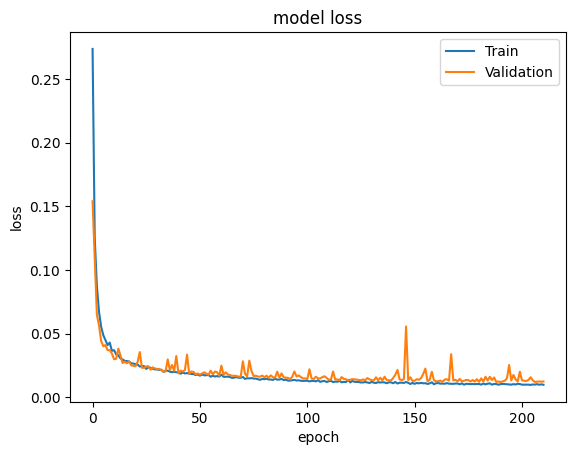

In [10]:
#plotting the results 
plot_loss(history)

In [11]:
# Save the Model to disk
from tensorflow.keras.saving import save_model
save_model(Autoencoder,"./Autoencoder/Autoencoder_model.h5")

In [51]:
# Evaluate the model using Test Dataset
eval = Autoencoder.evaluate(traffic_normal_test,traffic_normal_test)
print('Evaluation Loss',eval)

64126/64126 [==============================] - 124s 2ms/step - loss: 0.0075
Evaluation Loss 0.0074713751673698425


# Test the model on Attack traffic

In [85]:
traffic_attacks=next(pd.read_csv('../DataSet/Dataset_Attacks.csv',chunksize=500000))
Label=traffic_attacks['Label']
traffic_attacks.drop(columns=['Timestamp', 'Label'],inplace=True)
traffic_attacks.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
traffic_attacks.dropna(inplace=True)
traffic_attacks=scaler.fit_transform(traffic_attacks)

In [94]:
from tensorflow.keras.losses import MeanSquaredError as MSE
mse=MSE(name='mean_squared_error')
# Predic the Attack traffic
pred=Autoencoder.predict(traffic_attacks)
# Calculate the Loss of the attack traffic
attacks_error=mse(traffic_attacks,pred).numpy()
# Predic the Attack traffic
pred=Autoencoder.predict(traffic_normal_test)
# Calculate the Loss of the attack traffic
test_error=mse(traffic_normal_test,pred).numpy()
# Predic the Attack traffic     
pred=Autoencoder.predict(traffic_normal_train)
# Calculate the Loss of the attack traffic
train_error=mse(traffic_normal_train,pred).numpy()

256503/256503 [==============================] - 498s 2ms/step


In [95]:
print('Test Normal traffic Loss',test_error)
print('Train Normal traffic Loss',train_error)
print('Attacks Traffic Error',attacks_error)

Test Normal traffic Loss 0.007471421
Train Normal traffic Loss 0.009284985
Attacks Traffic Error 0.59256923


# evaluate model on mixed data

In [50]:
import random
attacks = "attacks_augmented.csv"
normal="../DataSet/normal_dataset.csv"
# Get the number of lines
attack_lines = sum(1 for l in open(attacks))
normal_lines = sum(1 for l in open(normal))


# attack_Size of 1% of lines
attack_size = int(attack_lines / 100)
normal_size = int(normal_lines / 1500)

# The row indices to skip - make sure 0 is not included to keep the header!
skip_idx_attack = random.sample(range(1, attack_lines), attack_lines - attack_size)
skip_idx_normal = random.sample(range(1, normal_lines), normal_lines - normal_size)

# Read the random sample of rows
df_attacks = pd.read_csv(attacks, skiprows=skip_idx_attack)
df_normal = pd.read_csv(normal, skiprows=skip_idx_normal)

print("attacks",df_attacks.shape)
print("normal",df_normal.shape)

attacks (7753, 79)
normal (5491, 79)


In [45]:
df= pd.concat([df_attacks,df_normal])
print("mixed data",df.shape)

mixed data (13244, 79)


In [46]:
df.loc[df['Label']!='BENIGN', 'Label'] = 'ATTACK'
df['Label'].unique()

array(['ATTACK', 'BENIGN'], dtype=object)

In [51]:

df_attacks.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
df_attacks.dropna(inplace=True)
X_attack=df_attacks.drop(columns=['Label'])
X_normal=df_normal.drop(columns=['Label'])
y=df_attacks['Label']
X=scaler.fit_transform(X)

print("X",len(X),"Y",len(y),"df_attacks",len(df_attacks))

X 7753 Y 7753 df_attacks 7753


In [48]:
del df_attacks,df_normal,df

In [12]:
#import liberaries for loading models
from keras.models import load_model
import os
#reading the H5 model
model = load_model(os.path.join('AutoEncoder','AutoEncoder_model.h5'))

In [15]:
# Evaluate the model using Test Dataset
eval = model.evaluate(traffic_normal_test,traffic_normal_test)
threshold=np.percentile(eval,98)
print('Normal trafic threshold',threshold)

64126/64126 [==============================] - 142s 2ms/step - loss: 0.0075
Normal trafic threshold 0.0074713751673698425


In [56]:
from tensorflow.keras.losses import MeanSquaredError as MSE
mse=MSE(name='mean_squared_error')
# Predic the Attack traffic
test_pred=model.predict(traffic_normal_test)

# Calculate the Loss of the attack traffic
test_error=[]
for i in range(0,len(pred)):
    error=mse(traffic_normal_test[i],test_pred[i]).numpy()
    test_error.append(error)
    print(error)

64126/64126 [==============================] - 104s 2ms/step
0.002539024
0.0020210205
0.0001908438
0.0086229835
0.00078911375
0.028891686
1.8456483e-05
0.0022317204
0.00017847329
0.00084163505
0.00017268091
0.00049549196
0.00018861037
0.0012095221
0.0003692771
0.0053105485
0.00022740636
0.009547827
4.9718e-05
8.768692e-05
0.00047465123
0.03602992
0.0001485524
0.00010574996
0.007086328
3.9867067e-05
0.00013844144
0.0005338761
0.016527802
0.00082832936
7.7712415e-05
0.0003203132
0.002428618
9.1864924e-05
0.0023415345
0.003168179
0.003510167
0.06414021
0.0023404781
0.00029434313
0.007877752
3.0165427e-05
4.9871996e-05
0.00021290946
0.00013180183
0.00027698392
0.00035641628
2.7809438e-05
0.00017798279
2.6402455e-05
0.00023252067
0.0007768688
0.00086917175
0.010791355
0.00092455867
0.0010155472
0.0003603823
8.965527e-05
0.29624465
0.0008211447
2.4378187e-05
0.0005155016
0.0021104703
0.0021578968
0.011675137
2.5253677e-05
0.0017811664
0.0054417704
0.010811623
0.00019278136
0.0008569998
0.000

In [97]:
threshold=np.percentile(test_error,98.6)
print('Normal trafic threshold',threshold)

Normal trafic threshold 0.0888851748704911


In [93]:
from tensorflow.keras.losses import MeanSquaredError as MSE
mse=MSE(name='mean_squared_error')
# Predic the Attack traffic
pred=model.predict(X)

# Calculate the Loss of the attack traffic
pred_error=[]
for i in range(0,len(pred)):
    error=mse(X[i],pred[i]).numpy()
    pred_error.append(error)
    print(error)

4293/4293 [==============================] - 9s 2ms/step
0.39911327
0.3553887
0.36481932
0.41576874
0.35388154
0.4111311
0.077738784
0.4296103
0.35351822
0.35115632
0.41837326
0.425577
0.40570927
0.10390464
0.41323617
0.41675568
0.36688662
0.5423488
0.40121377
0.56543124
0.42130777
0.42065895
0.37120605
0.4441611
0.3671783
0.38134435
0.39108077
0.43593985
0.42327714
0.3393171
0.4296277
0.35769868
0.36810935
0.38044924
0.41400695
0.40329957
0.35738087
0.425306
0.37876192
0.4263646
0.39960554
0.37490797
0.3624292
0.3526211
0.4012645
0.35609552
0.43539014
2.1557052
0.40979388
0.41681838
0.35931486
0.09242218
0.4196302
0.35770395
0.40263984
0.35509682
0.35910913
0.37489226
0.43535677
0.10459352
0.4297647
0.5644296
0.3682696
0.3725873
0.37577322
0.3747376
0.4110863
0.4243441
0.36247465
0.54535824
0.54815024
0.42828867
0.4384694
0.40322596
0.5564461
0.40716487
0.41010952
0.36310476
0.4096312
0.4449112
0.4179084
0.42705727
0.54454297
0.057366412
0.3963611
0.4152861
0.36998507
0.42487234
0.427

In [103]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

metrics = [
    "Accuracy",
    "F1 Score",
    "Precision",
    "Recall"
]

eval_results = []

y_pred = [ 'BENIGN' if i<= threshold else 'ATTACK' for i in pred_error]

Accuracy = accuracy_score(y, y_pred)
eval_results.append(Accuracy)
print("Accuracy",Accuracy)
  
F1_Score = f1_score(y, y_pred, average='weighted')
eval_results.append(F1_Score)
print("F1_Score",F1_Score)  

Precision = precision_score(y, y_pred, average='weighted')
eval_results.append(Precision)
print("Precision",Precision)  

Recall = recall_score(y, y_pred, average='weighted')
eval_results.append(Recall)
print("Recall",Recall)

plt.figure(figsize=(10,5))
plt.bar(metrics,eval_results)
plt.ylim([0.0, 1.0])
plt.xlabel('AutoEncoder')
plt.ylabel("%")
plt.title('Autoencoder Performence Comparison')
plt.savefig(os.path.join("./AutoEncoder", "AutoEncoder_Performance_plot.png"))
plt.close()

#calculate the confusion matrix
conf_mat = confusion_matrix(y, y_pred)

# convert the confusion matrix to a pandas DataFrame
conf_df = pd.DataFrame(conf_mat, index=y.unique(), columns=y.unique())

# plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_df, annot=True, fmt="d")
plt.title("Confusion matrix AutoEncoder")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig(os.path.join("AutoENcoder", "AutoEncoder_confusion_matrix.png"))
plt.close()


Accuracy 0.7740183732001689
F1_Score 0.7704565048802061
Precision 0.7931144029984687
Recall 0.7740183732001689


# Evaluation of multi model

In [1]:
import os
# import Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential 
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint 
from keras.utils import plot_model
import matplotlib.pyplot as plt
import gc

# load datasets
df = pd.read_csv('../DataSet/normal_dataset.csv')
df.drop(columns=['Label'],inplace=True)

# split normal dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
df=scaler.fit_transform(df)


In [2]:
#import liberaries for loading models
from keras.models import load_model
import os
#reading the H5 model
models={}
import glob
import h5py

directory_path = './AutoEncoder/Models/*.h5'  # Replace with the path to your directory

# Get a list of all file paths in the directory that end with .h5
file_paths = glob.glob(directory_path)
for file in file_paths:
    models[file.replace('./AutoEncoder/Models', '').replace('.h5', '')]=load_model(file)

In [3]:
results={'\\Autoencoder_model_layers_1_loss_logcosh': 0.0032836596947163343, '\\Autoencoder_model_layers_1_loss_mean_absolute_error': 0.030909722670912743, '\\Autoencoder_model_layers_1_loss_mean_squared_error': 0.014187504537403584, '\\Autoencoder_model_layers_1_loss_mean_squared_logarithmic_error': 0.0009000099380500615}
for key,model in models.items():
    if key not in results.keys():
        results[key]=model.evaluate(df,df)       
    else:
        print(key,results[key])

\Autoencoder_model_layers_1_loss_logcosh 0.0032836596947163343
\Autoencoder_model_layers_1_loss_mean_absolute_error 0.030909722670912743
\Autoencoder_model_layers_1_loss_mean_squared_error 0.014187504537403584
\Autoencoder_model_layers_1_loss_mean_squared_logarithmic_error 0.0009000099380500615
257481/257481 [==============================] - 472s 2ms/step - loss: 0.0088


In [4]:
r_df=pd.DataFrame([results])
r_df.to_csv("./AutoEncoder/results_8_models.csv",index=False)
print(results)

{'\\Autoencoder_model_layers_1_loss_logcosh': 0.0032836596947163343, '\\Autoencoder_model_layers_1_loss_mean_absolute_error': 0.030909722670912743, '\\Autoencoder_model_layers_1_loss_mean_squared_error': 0.014187504537403584, '\\Autoencoder_model_layers_1_loss_mean_squared_logarithmic_error': 0.0009000099380500615, '\\Autoencoder_model_layers_3_loss_logcosh': 0.0018371365731582046, '\\Autoencoder_model_layers_3_loss_mean_absolute_error': 0.027519380673766136, '\\Autoencoder_model_layers_3_loss_mean_squared_error': 0.00904960185289383, '\\Autoencoder_model_layers_3_loss_mean_squared_logarithmic_error': 0.008772673085331917}


In [42]:
import pandas as pd

data = {
    '\\Autoencoder_model_layers_1_loss_logcosh': 0.0032836596947163343,
    '\\Autoencoder_model_layers_1_loss_mean_absolute_error': 0.030909722670912743,
    '\\Autoencoder_model_layers_1_loss_mean_squared_error': 0.014187504537403584,
    '\\Autoencoder_model_layers_1_loss_mean_squared_logarithmic_error': 0.0009000099380500615,
    '\\Autoencoder_model_layers_3_loss_logcosh': 0.0018371365731582046,
    '\\Autoencoder_model_layers_3_loss_mean_absolute_error': 0.027519380673766136,
    '\\Autoencoder_model_layers_3_loss_mean_squared_error': 0.00904960185289383,
    '\\Autoencoder_model_layers_3_loss_mean_squared_logarithmic_error': 0.008772673085331917
}

# Extract the layers and loss functions from the dictionary keys
layers = [int(key.split('_')[3]) for key in data.keys()]  # Modified index to 3
loss_functions = [key.split('loss_')[1] for key in data.keys()]

# Create the DataFrame
df = pd.DataFrame({'Loss Function': loss_functions, 'Value': list(data.values()), 'Layers': layers})
# Pivot the DataFrame to the desired format
df_pivot = df.pivot(index='Layers', columns='Loss Function', values='Value').reset_index()

print(df_pivot)
df_pivot.to_csv("./AutoEncoder/results_8_models.csv",index=False)

Loss Function  Layers   logcosh  mean_absolute_error  mean_squared_error  \
0                   1  0.003284             0.030910            0.014188   
1                   3  0.001837             0.027519            0.009050   

Loss Function  mean_squared_logarithmic_error  
0                                    0.000900  
1                                    0.008773  


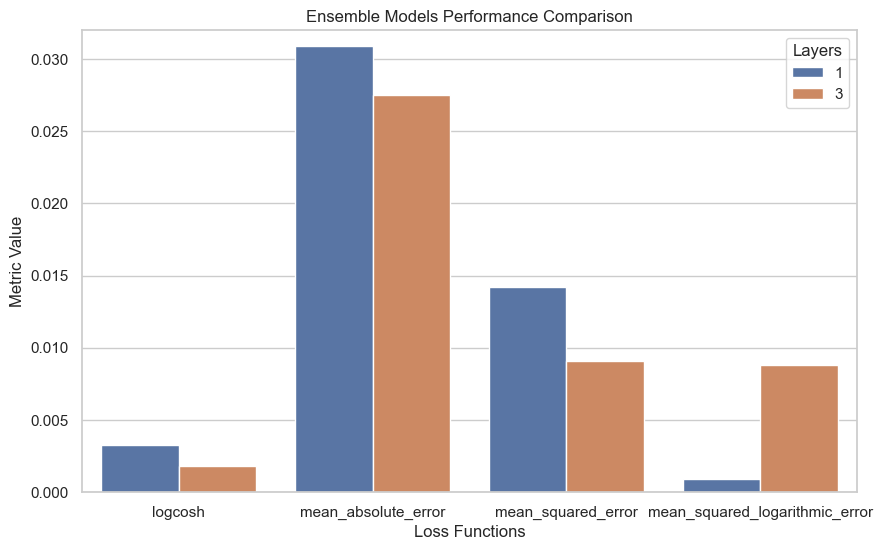

In [41]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Melt the DataFrame
melted_df = df_pivot.melt(id_vars="Layers", var_name="Loss Function", value_name="Value")

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x="Loss Function", y="Value", hue="Layers")
plt.title("Ensemble Models Performance Comparison")
plt.xlabel("Loss Functions")
plt.ylabel("Metric Value")
plt.ylim(0, 0.032)  # Adjust the y-axis limits if needed

# Display the plot
plt.show()


In [49]:
# Evaluate the model using Test Dataset
eval = model.evaluate(traffic_normal_test,traffic_normal_test)
threshold=np.percentile(eval,98)
print('Normal trafic threshold',threshold)
from tensorflow.keras.losses import MeanSquaredError as MSE
mse=MSE(name='mean_squared_error')
# Predic the Attack traffic
test_pred=model.predict(traffic_normal_test)

# Calculate the Loss of the attack traffic
test_error=[]
for i in range(0,len(pred)):
    error=mse(traffic_normal_test[i],test_pred[i]).numpy()
    test_error.append(error)
    print(error)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

metrics = [
    "Accuracy",
    "F1 Score",
    "Precision",
    "Recall"
]

eval_results = []

y_pred = [ 'BENIGN' if i<= threshold else 'ATTACK' for i in pred_error]

Accuracy = accuracy_score(y, y_pred)
eval_results.append(Accuracy)
print("Accuracy",Accuracy)
  
F1_Score = f1_score(y, y_pred, average='weighted')
eval_results.append(F1_Score)
print("F1_Score",F1_Score)  

Precision = precision_score(y, y_pred, average='weighted')
eval_results.append(Precision)
print("Precision",Precision)  

Recall = recall_score(y, y_pred, average='weighted')
eval_results.append(Recall)
print("Recall",Recall)

NameError: name 'traffic_normal_test' is not defined

In [57]:
from keras.losses import MeanSquaredError,MeanAbsoluteError,MeanSquaredLogarithmicError,LogCosh
losses = {
    '\\Autoencoder_model_layers_1_loss_logcosh': LogCosh(name='logcosh'),
    '\\Autoencoder_model_layers_1_loss_mean_absolute_error': MeanAbsoluteError(name='mean_absolute_error'),
    '\\Autoencoder_model_layers_1_loss_mean_squared_error': MeanSquaredError(name='mean_squared_error'),
    '\\Autoencoder_model_layers_1_loss_mean_squared_logarithmic_error': MeanSquaredLogarithmicError(name='mean_squared_logarithmic_error'),
    '\\Autoencoder_model_layers_3_loss_logcosh': LogCosh(name='logcosh'),
    '\\Autoencoder_model_layers_3_loss_mean_absolute_error': MeanAbsoluteError(name='mean_absolute_error'),
    '\\Autoencoder_model_layers_3_loss_mean_squared_error': MeanSquaredError(name='mean_squared_error'),
    '\\Autoencoder_model_layers_3_loss_mean_squared_logarithmic_error': MeanSquaredLogarithmicError(name='mean_squared_logarithmic_error')
}
ml= models
for name ,loss in losses.items():
    ml[name]=[loss,ml.pop(name)]
print(ml)

KeyError: '\\Autoencoder_model_layers_1_loss_logcosh'

In [59]:

X_attack=df_attacks.drop(columns=['Label'])
X_normal=df_normal.drop(columns=['Label'])

X_attack=scaler.fit_transform(X_attack)
X_normal=scaler.fit_transform(X_normal)


In [62]:
from keras.losses import MeanSquaredError,MeanAbsoluteError,MeanSquaredLogarithmicError,LogCosh
model_name = [
    '\\Autoencoder_model_layers_1_loss_logcosh',
    '\\Autoencoder_model_layers_1_loss_mean_absolute_error',
    '\\Autoencoder_model_layers_1_loss_mean_squared_error',
    '\\Autoencoder_model_layers_1_loss_mean_squared_logarithmic_error',
    '\\Autoencoder_model_layers_3_loss_logcosh',
    '\\Autoencoder_model_layers_3_loss_mean_absolute_error',
    '\\Autoencoder_model_layers_3_loss_mean_squared_error',
    '\\Autoencoder_model_layers_3_loss_mean_squared_logarithmic_error'
]

i=0
for loss,Autoencoder in ml.items():

    # Predict the Attack traffic
    pred = Autoencoder.predict(X_normal)

    # Calculate the Loss of the attack traffic
    test_error = loss(X_normal, pred).numpy()
    print(model_name[i] ,'on normal traffic:', test_error)

    # Predict the normal traffic
    pred = Autoencoder.predict(X_attack)

    # Calculate the Loss of the normal traffic
    train_error = loss(X_attack, pred).numpy()
    print(model_name[i], 'on attack traffic:', train_error)
    i+=1


172/172 [==============================] - 0s 2ms/step
\Autoencoder_model_layers_1_loss_logcosh on normal traffic: 0.01706018
243/243 [==============================] - 1s 2ms/step
\Autoencoder_model_layers_1_loss_logcosh on attack traffic: 0.13651925
172/172 [==============================] - 0s 2ms/step
\Autoencoder_model_layers_1_loss_mean_absolute_error on normal traffic: 0.07834309
243/243 [==============================] - 0s 2ms/step
\Autoencoder_model_layers_1_loss_mean_absolute_error on attack traffic: 0.2993047
172/172 [==============================] - 1s 3ms/step
\Autoencoder_model_layers_1_loss_mean_squared_error on normal traffic: 0.13913558
243/243 [==============================] - 1s 2ms/step
\Autoencoder_model_layers_1_loss_mean_squared_error on attack traffic: 0.45328498
172/172 [==============================] - 0s 2ms/step
\Autoencoder_model_layers_1_loss_mean_squared_logarithmic_error on normal traffic: 0.007180171
243/243 [==============================] - 1s 2ms